<a href="https://colab.research.google.com/github/nickweda/542-Semester-Project/blob/main/DR_v6e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Kaggle Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Import Labels

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load labels. 35,000 Train Labels. Left eye and right eye.'
# Dataframe
labels = pd.read_csv('/content/drive/MyDrive/drDataset/trainLabels.csv')

# Display the first few rows of the dataset
labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


**Data Exploration:**

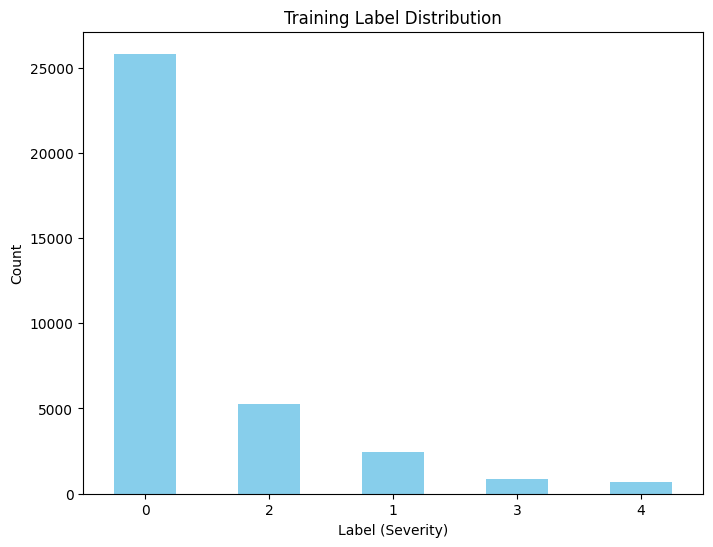

In [ ]:
# Count the occurrences of each label (assuming 'level' is the column name for labels)
label_counts = labels['level'].value_counts()

# Calculate percentages
label_percentages = (label_counts / len(labels)) * 100

# Display results
# print("Label Counts:")
# print(label_counts)
# print("\nLabel Percentages:")
# print(label_percentages)

# Optional: Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Training Label Distribution')
plt.xlabel('Label (Severity)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

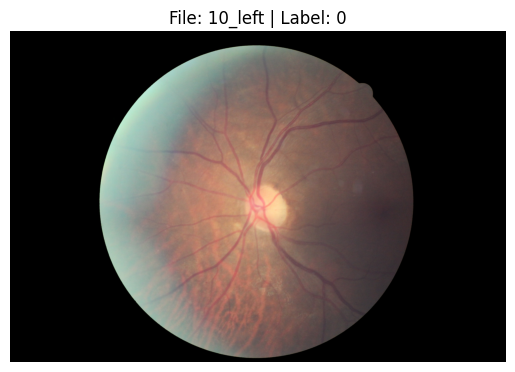

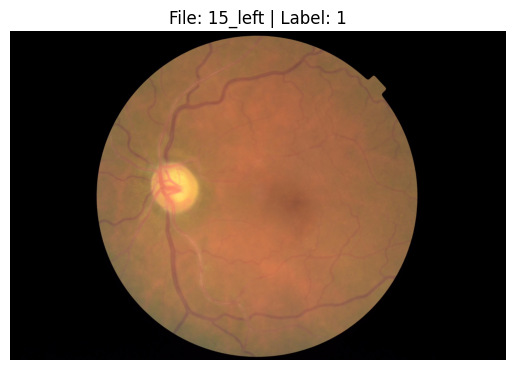

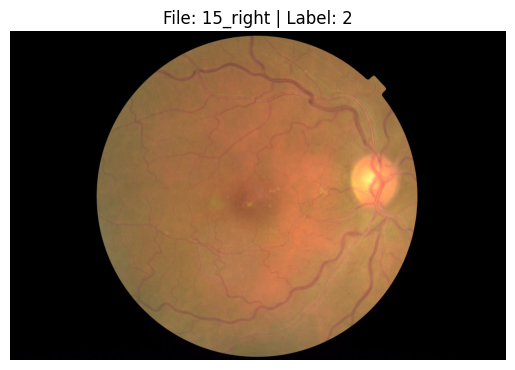

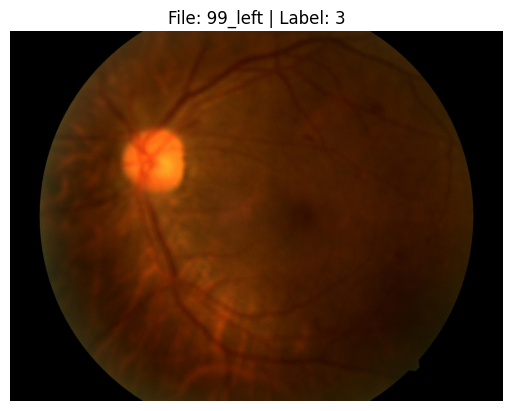

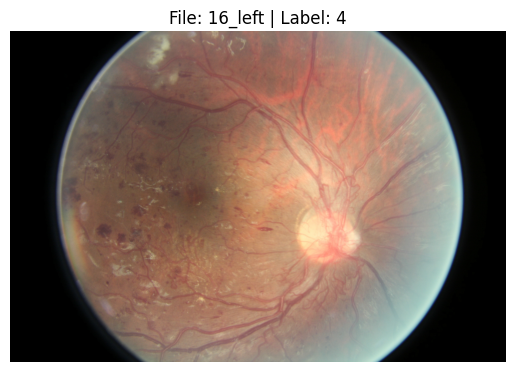

In [ ]:
# Get a sample image for each unique label
unique_labels = labels['level'].unique()
sampled_images = labels.groupby('level').first().reset_index()  # Get the first image for each label

for i in range(5): # 5 Labels in the data set. 0-4 (severity)
  image_filename = sampled_images.iloc[i]['image']
  image_path = f"/content/drive/MyDrive/drDataset/train/{image_filename}.jpeg"
  image_label = sampled_images.iloc[i]['level']

  img = Image.open(image_path)

  plt.figure()
  plt.imshow(img)
  plt.title(f"File: {image_filename} | Label: {image_label}")
  plt.axis('off')
  plt.show()

**Image Pre-Processing - Resizing and Augmentation**

In [ ]:
# Resize the Images to 224x224 for ResNet
import os
import tensorflow as tf
import numpy as np
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Define source and target directories
source_dir = '/content/drive/MyDrive/drDataset/train'
target_dir = '/content/drive/MyDrive/drDataset/train_pre_processed_ar'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)


# Region of Interest Cropping -
# Direct resizing even with loss of aspect ratio yields the some good results but causes distortion in many images
# reflective padding distorts the image too much
# Zero Padding introduces noise, its necessary to keep aspect ratio, but we want to minimize how much black border is added
def crop_resize_with_aspect_ratio(img, target_size=224):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img_cropped = img[y:y+h, x:x+w]
    else:
        img_cropped = img

    # Get the original aspect ratio
    h, w, c = img_cropped.shape
    aspect_ratio = w / h

    # Resize while maintaining aspect ratio
    if w > h:
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    img_resized = cv2.resize(img_cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Add padding to make the image square
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return img_padded



# Function to enhance image contrast using CLAHE - Reduces Noise
def enhance_contrast(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

# Function to resize image
def resize_image(img, target_size=224):
    return tf.image.resize(img, (target_size, target_size))

# Data augmentation using ImageDataGenerator
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)

# Process and augment specific images
def process_images(source_dir, target_dir, target_size=224):

    # Iterate through all files in the source directory
    for image_filename in tqdm(os.listdir(source_dir)):

        img_path = os.path.join(source_dir, image_filename)

        # All images from main train directory
        if os.path.exists(img_path):
            # Load image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Step 1: Crop or pad to ROI
            img = crop_resize_with_aspect_ratio(img)

            # Step 2: Enhance image contrast and Noise Reduction
            img = enhance_contrast(img)

            # Step 3: Resize image
            img = resize_image(img, target_size)


            # Perform Data Augmentation
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            augment_iter = data_gen.flow(img_array, batch_size=1)
            aug_img = augment_iter.next()[0]
            aug_img = tf.cast(aug_img, tf.uint8)
            aug_save_path = os.path.join(target_dir, f"{image_filename}")
            tf.keras.preprocessing.image.save_img(aug_save_path, aug_img)



# Run the function for the sampled images
process_images(source_dir, target_dir)


100%|██████████| 35127/35127 [4:31:27<00:00,  2.16it/s]


**Undersample - Reduce the majority classes to the size of the minority classes**

In [4]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00


In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler instance

# Undersample only the majority class


# Calculate the count of each label
label_counts = labels['level'].value_counts()
label_0_count = label_counts.get(0, 0)  # Get count of label 0, default to 0 if not found
label_1_count = label_counts.get(1, 0)  # Get count of label 1, default to 0 if not found
label_2_count = label_counts.get(2, 0)  # Get count of label 2, default to 0 if not found

# // is the floor function

sampling_strategy = {0: label_2_count//3, 1: label_1_count//2, 2: label_2_count//3}
undersampler = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state=42)

# Undersample every class to the size of the minority class
#undersampler = RandomUnderSampler(random_state=42)

# Reshape your data if necessary - needed because of how RandomUnderSampler expects the data
# Assuming your 'train_df' DataFrame has 'image' and 'level' columns
X = labels['image'].values.reshape(-1, 1)
y = labels['level'].values

# Undersample the majority class
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with the undersampled data
undersampled_labels = pd.DataFrame({'image': X_resampled.flatten(), 'level': y_resampled})

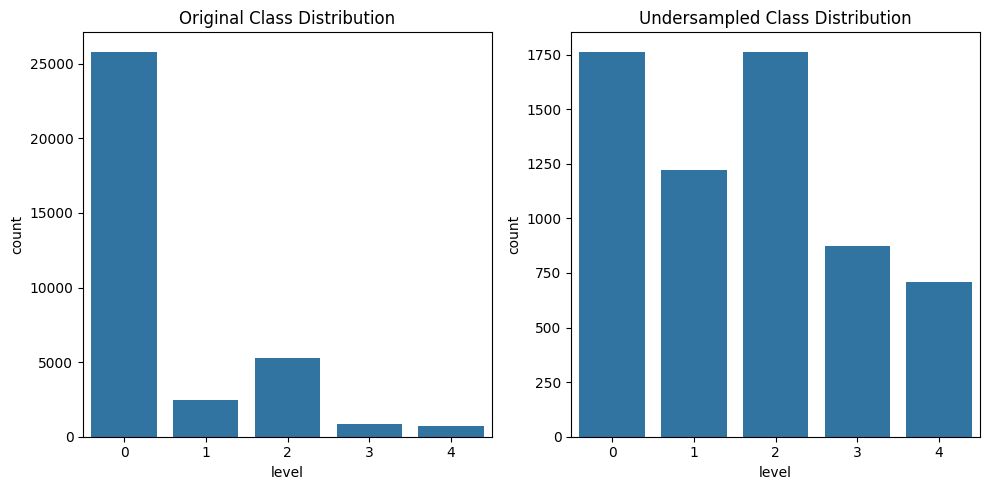

In [6]:
# Visualize the new sampling
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='level', data=labels)
plt.title('Original Class Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='level', data=undersampled_labels)
plt.title('Undersampled Class Distribution')

plt.tight_layout()
plt.show()

**Oversample the minority classes - SMOTE w/ Light Stratifcation**

In [7]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [8]:
# Straight OverSampling
# Create a copy of the original DataFrame
undersampled_labels = undersampled_labels.copy()

# Create a LabelEncoder instance
encoder = LabelEncoder()

# image name feature is a string (e.g. "10_left")
# We need to transform this into a numerical value for SMOTE
# Fit the encoder and transform the image names in the copy
undersampled_labels['image_encoded'] = encoder.fit_transform(undersampled_labels['image'])


min_samples = 1400

sampling_strategy = {1: min_samples, 3: min_samples, 4: min_samples}

# SMOTE's raw behavior: Oversample all minority classes to the same size as the majority class
oversampler = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Use the encoded image labels as input for SMOTE
X = undersampled_labels[['image_encoded']].values
y = undersampled_labels['level'].values

# Oversample the minority classes
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new DataFrame with the oversampled data, including the original image names
oversampled_labels = pd.DataFrame({'image': encoder.inverse_transform(X_resampled.flatten()), 'level': y_resampled})

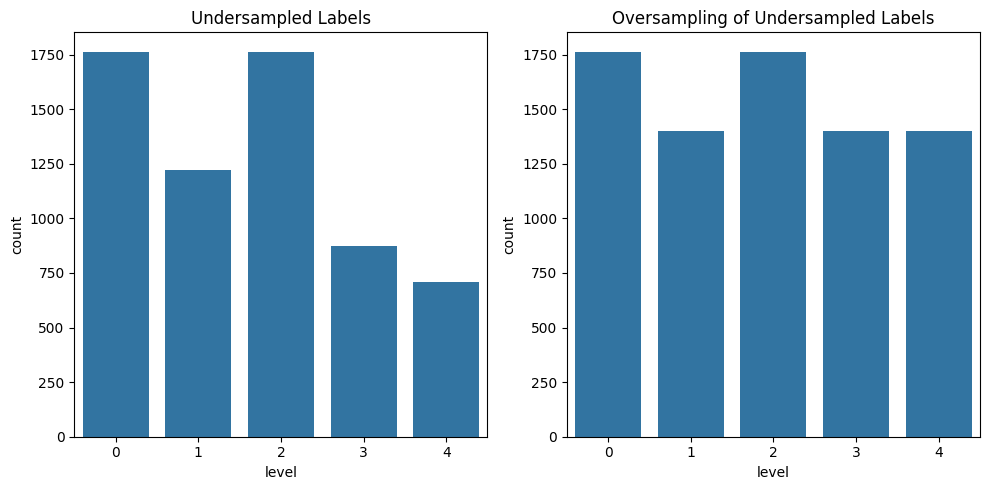

In [9]:
# Visualize the new sampling
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='level', data=undersampled_labels)
plt.title('Undersampled Labels')

plt.subplot(1, 2, 2)
sns.countplot(x='level', data=oversampled_labels)
plt.title('Oversampling of Undersampled Labels')

plt.tight_layout()
plt.show()

**Oversample the minority classes - SMOTE Algorithm
with Full stratified sampling of minority classes**

In [ ]:
# # Preserving Distribution


# # Create a copy of the original DataFrame
# labels_copy = labels.copy()

# # Create a LabelEncoder instance
# encoder = LabelEncoder()

# # image name feature is a string (e.g. "10_left")
# # We need to transform this into a numerical value for SMOTE
# # Fit the encoder and transform the image names in the copy
# labels_copy['image_encoded'] = encoder.fit_transform(labels_copy['image'])

# # Sampling Strategy Parameter,
# # Can control the exact ammount of oversamples for each class

# # I am going to try and represent the original distribution from classes 1-4 and then oversample

# # Scaling factor
# scale = 4

# original_counts = labels['level'].value_counts()
# print(f'Original Distribution : ', original_counts)

# # Create a dictionary to store the scaled counts
# scaled_counts = {}

# # Scaling factor - tuning parameter
# scale = 4

# # Iterate through the original counts and scale the minority classes
# for level, count in original_counts.items():
#     if level != 0:  # Exclude the majority class (level 0)
#         scaled_counts[level] = count * scale
#     else:
#         scaled_counts[level] = count  # Keep the majority class count unchanged

# # Print the scaled counts
# print(f'Scaled Counts :', scaled_counts)

# oversampler = SMOTE(sampling_strategy=scaled_counts, random_state=42)

# # SMOTE's original behavior: Oversample all minority classes to the same size as the majority class
# #oversampler = SMOTE(random_state=42)

# # Use the encoded image labels as input for SMOTE
# X = labels_copy[['image_encoded']].values
# y = labels_copy['level'].values

# # Oversample the minority classes
# X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Create a new DataFrame with the oversampled data, including the original image names
# oversampled_labels = pd.DataFrame({'image': encoder.inverse_transform(X_resampled.flatten()), 'level': y_resampled})

Original Distribution :  level
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64
Scaled Counts : {0: 25810, 2: 21168, 1: 9772, 3: 3492, 4: 2832}


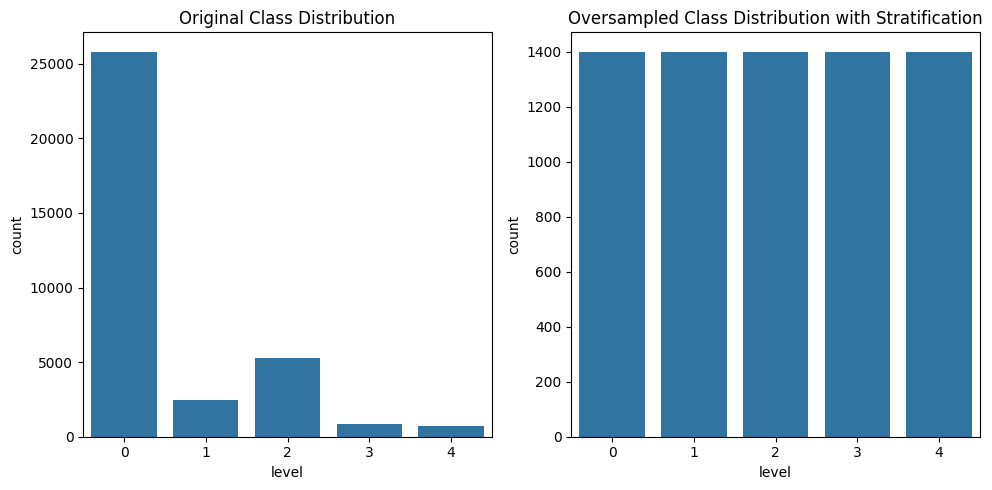

In [ ]:
# # Visualize the new sampling
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# sns.countplot(x='level', data=labels)
# plt.title('Original Class Distribution')

# plt.subplot(1, 2, 2)
# sns.countplot(x='level', data=oversampled_labels)
# plt.title('Oversampled Class Distribution with Stratification')

# plt.tight_layout()
# plt.show()

**Splitting Data into Train/Validate sets w/Stratification.**

In [10]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import os

# Define the image directory
image_dir = '/content/drive/MyDrive/drDataset/train_pre_processed_ar'

# Split the data into training and validation sets with stratification
train_df, val_df = train_test_split(
    oversampled_labels, # New Labels
    test_size=0.2,
    random_state=42,
    stratify=oversampled_labels['level']
)

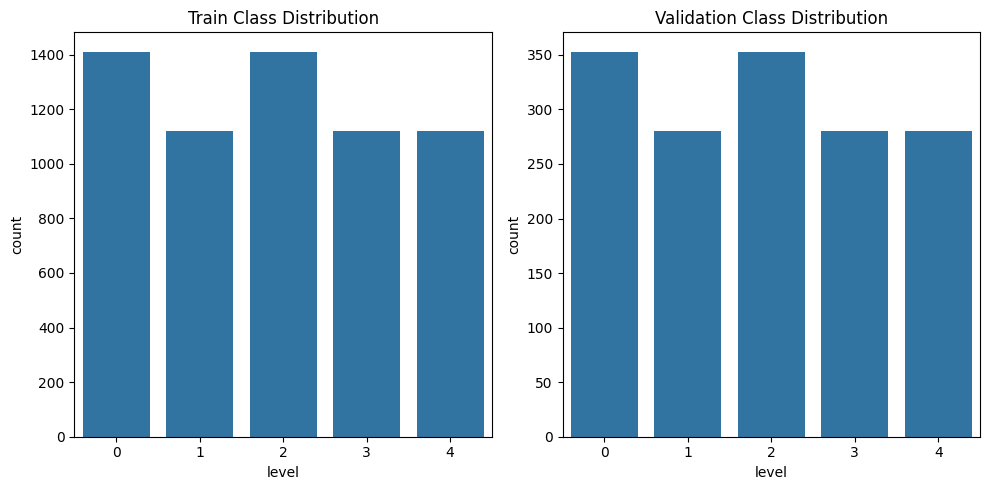

In [11]:
# Visualize the train-test split I just did above

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='level', data=train_df)
plt.title('Train Class Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='level', data=val_df)
plt.title('Validation Class Distribution')

plt.tight_layout()
plt.show()

**ResNest-50 Code**

In [12]:
from keras.applications import EfficientNetB0

In [13]:
# Normalize Images for res-net

# Define a function to load and preprocess images
def preprocess_image(image_path, label):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image into a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    # image = tf.image.resize(image, [224, 224]) # Images are already pre-processed
    # Convert image to float32 and normalize using ResNet-50's preprocessing
    #image = tf.keras.applications.resnet50.preprocess_input(image)

    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label


In [14]:
# Create Tensorflow datasets - from our train/test splits

# Prepare file paths and labels
train_filepaths = train_df['image'].apply(lambda x: os.path.join(image_dir, f"{x}.jpeg")).values
train_labels = train_df['level'].values

val_filepaths = val_df['image'].apply(lambda x: os.path.join(image_dir, f"{x}.jpeg")).values
val_labels = val_df['level'].values

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_filepaths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_filepaths, val_labels))

# Apply the preprocessing function
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the datasets.
# How many images get fed in at a time.
batch_size = 128 # Larger number means faster training

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [15]:
train_size = train_dataset.cardinality().numpy()
val_size = val_dataset.cardinality().numpy()

total_train_images = train_size * batch_size
total_val_images = val_size * batch_size

print(f"Train dataset batches: {train_size}")
print(f"Validation dataset batches: {val_size}")

print(f"\nTotal train images: {total_train_images}")
print(f"Total validation images: {total_val_images}")

Train dataset batches: 49
Validation dataset batches: 13

Total train images: 6272
Total validation images: 1664


In [16]:
# Build the Res-net-50 model
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Load the ResNet-50 model without the top layers
# base_model = ResNet50(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224, 224, 3)
# )

# Replace the base_model instantiation with:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers except the last block - Common Practice
# Initial layers contain generic features
# for layer in base_model.layers[:-11]:  # All but last 11 layers (approx. last block)
#     layer.trainable = False

for layer in base_model.layers[:-50]:  # Freeze more layers initially for EfficientNetB0
    layer.trainable = False


# Create the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Control Overfitting

# Add Dropout Layers. Randomly drops out a fraction of neurons
# Higher = more training time
x = tf.keras.layers.Dropout(rate=0.2)(x)  # Add dropout layers. 0.2, 0.3, 0.5, 0.8 is max

# Add L2 regularization
outputs = Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(5, activation='softmax')(x)  # Assuming 5 classes (levels 0 to 4)
model = Model(inputs, outputs)

# Compile the model
model.compile(
    # Learning Rate, slower can mean more accuracy, higher leads to faster training.
    # Controls the step size, how much weights are updated
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Make adjustments here!!!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model

epochs = 15  # Tuning Parameter


history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset, # val_accuracy calculated at the end of each epoch
)



16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/15
49/49 [==============================] - 234s 2s/step - loss: 1.5124 - accuracy: 0.3206 - val_loss: 1.4149 - val_accuracy: 0.3836
Epoch 2/15
49/49 [==============================] - 100s 2s/step - loss: 1.3920 - accuracy: 0.4013 - val_loss: 1.4015 - val_accuracy: 0.3777
Epoch 3/15
49/49 [==============================] - 105s 2s/step - loss: 1.3274 - accuracy: 0.4355 - val_loss: 1.3534 - val_accuracy: 0.4133
Epoch 4/15
49/49 [==============================] - 100s 2s/step - loss: 1.2721 - accuracy: 0.4634 - val_loss: 1.3416 - val_accuracy: 0.4360
Epoch 5/15
49/49 [==============================] - 102s 2s/step - loss: 1.2282 - accuracy: 0.4817 - val_loss: 1.3382 - val_accuracy: 0.4353
Epoch 6/15
49/49 [==============================] - 103s 2s/step - loss: 1.1706 - accuracy: 0.5184 - val_loss: 1.3593 - val_accuracy: 0.4353
Epoch 7/15
49/49 [==============================] - 100s 2s/step - loss: 1.1139 - accurac

In [17]:

# Save the model
import os

model_dir = '/content/drive/MyDrive/drDataset/model'

# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model to the specified directory
model_path = os.path.join(model_dir, 'dr_model_v6e.keras')
model.save(model_path)

**Learning Rate Range Test (LRRT) to find an ideal learning rate for the model**

In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
# import keras_tuner as kt
# from keras.applications import ResNet50
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras.models import Model

In [ ]:
# def build_model(hp):
#     # Load the ResNet-50 model without the top layers
#     base_model = ResNet50(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(224, 224, 3)
#     )

#     # Freeze all layers except the last block
#     for layer in base_model.layers[:-11]:
#         layer.trainable = False

#     # Create the model
#     inputs = tf.keras.Input(shape=(224, 224, 3))
#     x = base_model(inputs, training=False)
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(5, activation='softmax')(x)
#     model = Model(inputs, outputs)

#     # Define the learning rate as a hyperparameter
#     hp_learning_rate = hp.Float(
#         'learning_rate',
#         min_value=1e-5,  # Minimum learning rate
#         max_value=1e-2,  # Maximum learning rate
#         sampling='log'  # Sample learning rates on a logarithmic scale
#     )

#     # Compile the model
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

In [ ]:
# # Create the tuner
# # Hyperband uses a bandit-based approach to dynamically allocate epochs to promising learning rates.
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',  # Optimize for validation accuracy
#     max_epochs=10, # The hyperband won't run 10 epochs for each trial, it will stop if it sees it won't perform well
#     factor=3,  # Reduction factor for Hyperband
#     directory='lr_range_test',  # Directory to store results
#     project_name='resnet50_lr'  # Project name
# )

# # Run the tuner
# tuner.search(
#     train_dataset,
#     epochs=10,
#     validation_data=val_dataset
# )

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_learning_rate = best_hps.get('learning_rate')
# print(f"Best learning rate: {best_learning_rate}")

94765736/94765736 [==============================] - 0s 0us/step


**Performance Metrics**

1/1 [==============================] - 2s 2s/step
Accuracy: 0.4334
Classification Report:
               precision    recall  f1-score   support

           0     0.4011    0.4249    0.4127       353
           1     0.3038    0.3179    0.3106       280
           2     0.3810    0.4533    0.4140       353
           3     0.5700    0.4071    0.4750       280
           4     0.6062    0.5607    0.5826       280

    accuracy                         0.4334      1546
   macro avg     0.4524    0.4328    0.4390      1546
weighted avg     0.4466    0.4334    0.4365      1546



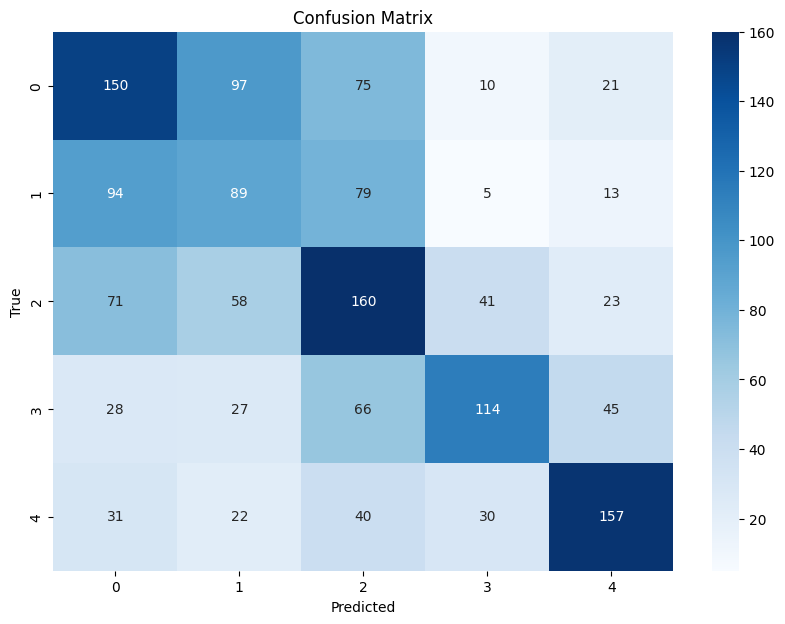

Macro-average ROC AUC score: 0.6449
Quadratic Weighted Kappa: 0.5107


In [18]:
# Performance Metrics

#Obtain predictions from validation set
# Get true labels from the validation DataFrame
val_labels = val_df['level'].values

# Since val_dataset is batched, we'll collect predictions and true labels
predictions = []
true_labels = []

for images, labels in val_dataset:
    # Get model predictions (probabilities)
    preds = model.predict(images)
    # Convert probabilities to predicted class indices
    preds_classes = np.argmax(preds, axis=1)
    predictions.extend(preds_classes)
    true_labels.extend(labels.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")


# Precision-Recall-F1score
from sklearn.metrics import classification_report

report = classification_report(true_labels, predictions, digits=4)
print("Classification Report:\n", report)


# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Area Under the ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
classes = [0, 1, 2, 3, 4]
true_labels_binarized = label_binarize(true_labels, classes=classes)
predictions_binarized = label_binarize(predictions, classes=classes)

# Compute the ROC AUC score
roc_auc = roc_auc_score(true_labels_binarized, predictions_binarized, average='macro')
print(f"Macro-average ROC AUC score: {roc_auc:.4f}")


# Quadratic Weighted Kappa

from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predictions, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa:.4f}")